In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Load the data

In [122]:
!mkdir data && wget https://github.com/sdip15fa/weather-predict/raw/master/data/processed_data.csv -O data/processed_data.csv

input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

mkdir: cannot create directory ‘data’: File exists


Convert the 'Date' and 'Time' columns to integers

In [123]:
df["Temperature"] = df["Temperature"].astype(float)
df["Wind Speed"] = df["Wind Speed"].astype(float)
df["Rainfall"] = df["Rainfall"].astype(float)
df["Wind Direction"] = df["Wind Direction"].astype(float)

Filter and replace outliers

In [124]:
df['Temperature'] = df['Temperature'].replace(3276.7, np.nan)
df['Wind Speed'] = df['Wind Speed'].replace(32767, np.nan)
df['Rainfall'] = df['Rainfall'].replace(32767, np.nan)
df['Wind Direction'] = df['Wind Direction'].replace(32767, np.nan)
df['Temperature'] = df['Temperature'].mask((df['Temperature'] >= df['Temperature'].quantile(0.99)), np.nan)
df['Wind Speed'] = df['Wind Speed'].mask((df['Wind Speed'] >= df['Wind Speed'].quantile(0.99)), np.nan)
df['Rainfall'] = df['Rainfall'].mask((df['Rainfall'] >= df['Rainfall'].quantile(0.99)), np.nan)
df['Wind Direction'] = df['Wind Direction'].mask((df['Wind Direction'] < 0) | (df['Wind Direction'] > 360), np.nan)

In [125]:
df[df.isna().any(axis=1)]

,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall
36,2008-01-02 12:00:00,2008.0,1.0,2.0,12.0,1.0,NaN,NaN,NaN,NaN
38,2008-01-02 14:00:00,2008.0,1.0,2.0,14.0,1.0,11.2,19.0,NaN,0.0
39,2008-01-02 15:00:00,2008.0,1.0,2.0,15.0,1.0,10.7,13.0,NaN,0.0
59,2008-01-03 11:00:00,2008.0,1.0,3.0,11.0,1.0,11.9,15.0,NaN,0.0
111,2008-01-05 15:00:00,2008.0,1.0,5.0,15.0,1.0,16.0,10.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
135791,2023-06-28 23:00:00,2023.0,6.0,28.0,23.0,1.0,21.5,110.0,101.0,NaN
135804,2023-06-29 12:00:00,2023.0,6.0,29.0,12.0,1.0,NaN,15.0,299.0,0.0
135805,2023-06-29 13:00:00,2023.0,6.0,29.0,13.0,1.0,NaN,20.0,233.0,0.0
135806,2023-06-29 14:00:00,2023.0,6.0,29.0,14.0,1.0,NaN,12.0,270.0,0.0


In [126]:
df = df.fillna(method='ffill')

Prepare the data for LSTM

Remove rows with missing values

In [127]:
df = df.dropna().reset_index()

In [128]:
df

,index,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall
0,0,2008-01-01 00:00:00,2008.0,1.0,1.0,0.0,1.0,3.6,107.0,49.0,0.0
1,1,2008-01-01 01:00:00,2008.0,1.0,1.0,1.0,1.0,3.0,103.0,42.0,0.0
2,2,2008-01-01 02:00:00,2008.0,1.0,1.0,2.0,1.0,2.3,101.0,39.0,0.0
3,3,2008-01-01 03:00:00,2008.0,1.0,1.0,3.0,1.0,2.4,92.0,47.0,0.0
4,4,2008-01-01 04:00:00,2008.0,1.0,1.0,4.0,1.0,2.0,102.0,47.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
135834,135834,2023-06-30 18:00:00,2023.0,6.0,30.0,18.0,1.0,23.0,27.0,194.0,0.0
135835,135835,2023-06-30 19:00:00,2023.0,6.0,30.0,19.0,1.0,22.8,41.0,191.0,0.0
135836,135836,2023-06-30 20:00:00,2023.0,6.0,30.0,20.0,1.0,22.5,17.0,150.0,0.0
135837,135837,2023-06-30 21:00:00,2023.0,6.0,30.0,21.0,1.0,21.8,30.0,166.0,0.0


Check if any hours are missing

In [129]:
# Get the minimum and maximum DateTime values in the DataFrame
min_time = df['DateTime'].min()
max_time = df['DateTime'].max()

# Create a complete sequence of hours using pandas date_range
complete_hours = pd.date_range(start=min_time, end=max_time, freq='H')

# Extract the unique hours from the DataFrame
existing_hours = pd.to_datetime(df['DateTime']).unique()

# Find the missing hours by comparing the complete sequence with the existing hours
missing_hours = [hour for hour in complete_hours if hour not in existing_hours]

# Print the missing hours
print(missing_hours)

[]


In [130]:
time_steps = 72  # Number of time steps for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

In [131]:
features_keys = ['Temperature', 'Wind Speed',
               'Rainfall']

Scale the temperature, wind speed, rainfall, and wind direction values

In [132]:
features = df[features_keys].copy()
scaled_features = scaler.fit_transform(features)

In [133]:
scaled_features

array([[0.30670927, 0.59776536, 0.        ],
       [0.28753994, 0.57541899, 0.        ],
       [0.26517572, 0.56424581, 0.        ],
       ...,
       [0.91054313, 0.09497207, 0.        ],
       [0.88817891, 0.16759777, 0.        ],
       [0.88817891, 0.19553073, 0.        ]])

Create sequences of input data and corresponding target values

In [134]:
data = []
target = []
for i in range(1, len(scaled_features) - time_steps):
    # exclude the target
    data.append(scaled_features[i:i+time_steps])
    # Only the temperature is the target
    target.append(scaled_features[i+time_steps])

In [135]:
data = np.array(data)
target = np.array(target)


Split the dataset into training and validation sets

In [136]:
split = 0.1
exclude_index = int(len(data) * (1-split))
train_data, train_target = data[:exclude_index], target[:exclude_index]
val_data, val_target = data[exclude_index:], target[exclude_index:]


Build the LSTM model architecture

In [137]:
import tensorflow as tf
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True,
                         input_shape=(time_steps, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(time_steps, len(features_keys))),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(features_keys))
])


2023-07-01 11:06:44.012662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 11:06:44.014539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 11:06:44.015353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Compile the model

In [138]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

Define early stopping and learning rate scheduler

In [139]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Train the LSTM model

In [140]:
batch_size = 4096
epochs = 100
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


2023-07-01 11:06:44.837067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 11:06:44.839383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 11:06:44.840780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/30 [====================>.........] - ETA: 52s - loss: 0.1729

Make predictions using the trained LSTM model

In [ ]:
predictions = model.predict(val_data)

Rescale the predictions back to the original range

In [ ]:
scaled_predictions = pd.DataFrame(predictions, columns=features_keys)
predictions = pd.DataFrame(scaler.inverse_transform(
    predictions), columns=features_keys)
predicted_temperature = predictions["Temperature"]


In [ ]:
val_target = pd.DataFrame(val_target, columns=features_keys)
val_target_rescaled = pd.DataFrame(scaler.inverse_transform(val_target), columns=features_keys)
train_target = pd.DataFrame(train_target, columns=features_keys)
train_target_rescaled = pd.DataFrame(scaler.inverse_transform(train_target), columns=features_keys)

Calculate MSE and MAE

In [ ]:
mse = mean_squared_error(val_target_rescaled["Temperature"], predictions["Temperature"])
mae = mean_absolute_error(val_target_rescaled["Temperature"], predictions["Temperature"])

In [ ]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Visualize the actual vs. predicted temperatures for the validation set

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), val_target_rescaled["Temperature"], label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Visualize the actual vs. predicted temperatures for the training set

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_target)), train_target["Temperature"], label='Actual')
plt.plot(range(len(train_target)), pd.DataFrame(model.predict(
    train_data), columns=features_keys)["Temperature"], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Training Set)')
plt.legend()
plt.show()

Save the trained model

In [ ]:
model.save("lstm.keras")

In [ ]:
scaled_features
scaled_features.copy()[-time_steps:].shape

In [ ]:
model = tf.keras.models.load_model("lstm.keras")

data = scaled_features.copy()[-time_steps:]
predicted = []

for i in range(1, 31):
    scaled_prediction = model.predict(data.reshape(1, time_steps, len(features_keys)))
    prediction = scaler.inverse_transform(scaled_prediction)[0]
    print(f"{i} hour(s) prediction:", list(map(lambda x: round(x, 6),prediction)))
    # print(prediction[0], data, np.append(data, prediction[0]))
    data = np.vstack((data, scaled_prediction))
    data = np.delete(data, 0, axis=0)
    predicted.append(prediction)

2023-06-30 23:09:27.978430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 23:09:27.979929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 23:09:27.980872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
1 hour(s) prediction: [21.735493, 39.494274, 0.031494]
1/1 [==============================] - 0s 31ms/step
2 hour(s) prediction: [21.71678, 43.912514, 0.021867]
1/1 [==============================] - 0s 29ms/step
3 hour(s) prediction: [21.678608, 47.2656, 0.010562]
1/1 [==============================] - 0s 31ms/step
4 hour(s) prediction: [21.63285, 49.65404, 0.005001]
1/1 [==============================] - 0s 30ms/step
5 hour(s) prediction: [21.594131, 51.287506, 0.003969]
1/1 [==============================] - 0s 27ms/step
6 hour(s) prediction: [21.573551, 52.274418, 0.004892]
1/1 [==============================] - 0s 31ms/step
7 hour(s) prediction: [21.588757, 52.635353, 0.005731]
1/1 [==============================] - 0s 30ms/step
8 hour(s) prediction: [21.658337, 52.33173, 0.004799]
1/1 [==============================] - 0s 26ms/step
9 hour(s) prediction: [21.796547, 51.291832, 0.000958]
1/1 [==============================] - 0s 31m

In [ ]:
results = pd.DataFrame(predicted, columns=features_keys)
results.to_csv("predict.csv")

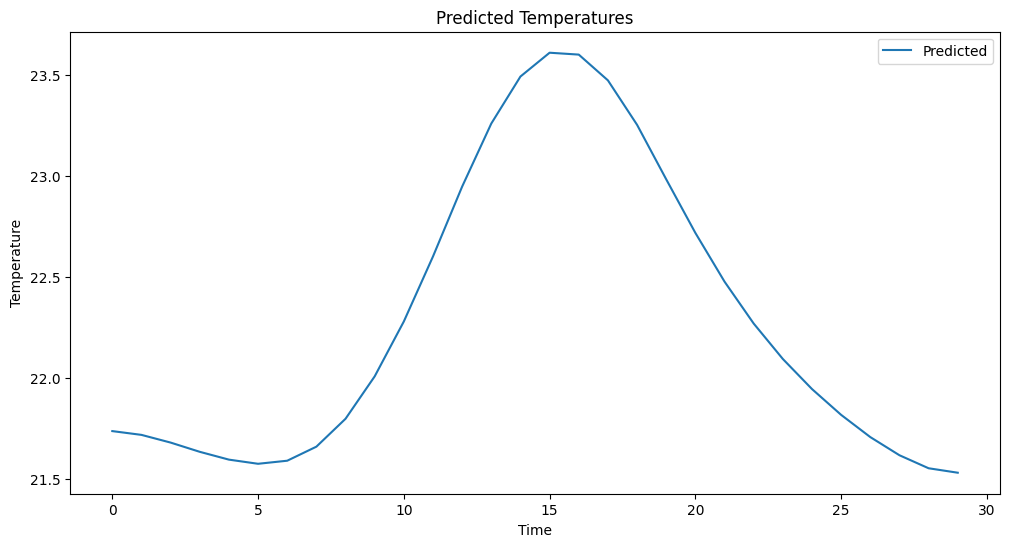

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(30), np.array(predicted)[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()